In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np # Algebra linéaire et calculs
import sklearn
from sklearn.preprocessing import LabelEncoder # Données categoriques vers numériques
from sklearn.model_selection import train_test_split # Decoupage en training et testing
from sklearn.metrics import accuracy_score # Calcul de la precision d’un modèle
from sklearn.impute import KNNImputer # Imputation de valeurs avec K-PP voisins
from sklearn.neighbors import KNeighborsClassifier # Classification K-PP voisins
from sklearn.linear_model import LinearRegression # Regression linéaire
from sklearn.ensemble import RandomForestRegressor # Regression Random Forest
from sklearn.ensemble import RandomForestClassifier # Classifieur Random Forest
from sklearn.metrics import mean_squared_error # Performance des modèles de regression
from sklearn.impute import SimpleImputer # Imputation de valeurs manquantes avec une stratégie simple
from xgboost import XGBClassifier #

data = pd.read_csv("heart_disease_uci.csv")

print(data.isnull().sum())


id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [24]:
def missing_values(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
    " columns that have missing values.")
    # Return the dataframe with missing information
    return mis_val_table_ren_columns
missing_values_table = missing_values(data)
print(missing_values_table)

Your selected dataframe has 16 columns.
There are 10 columns that have missing values.
          Missing Values  % of Total Values
ca                   611               66.4
thal                 486               52.8
slope                309               33.6
fbs                   90                9.8
oldpeak               62                6.7
trestbps              59                6.4
exang                 55                6.0
thalch                55                6.0
chol                  30                3.3
restecg                2                0.2


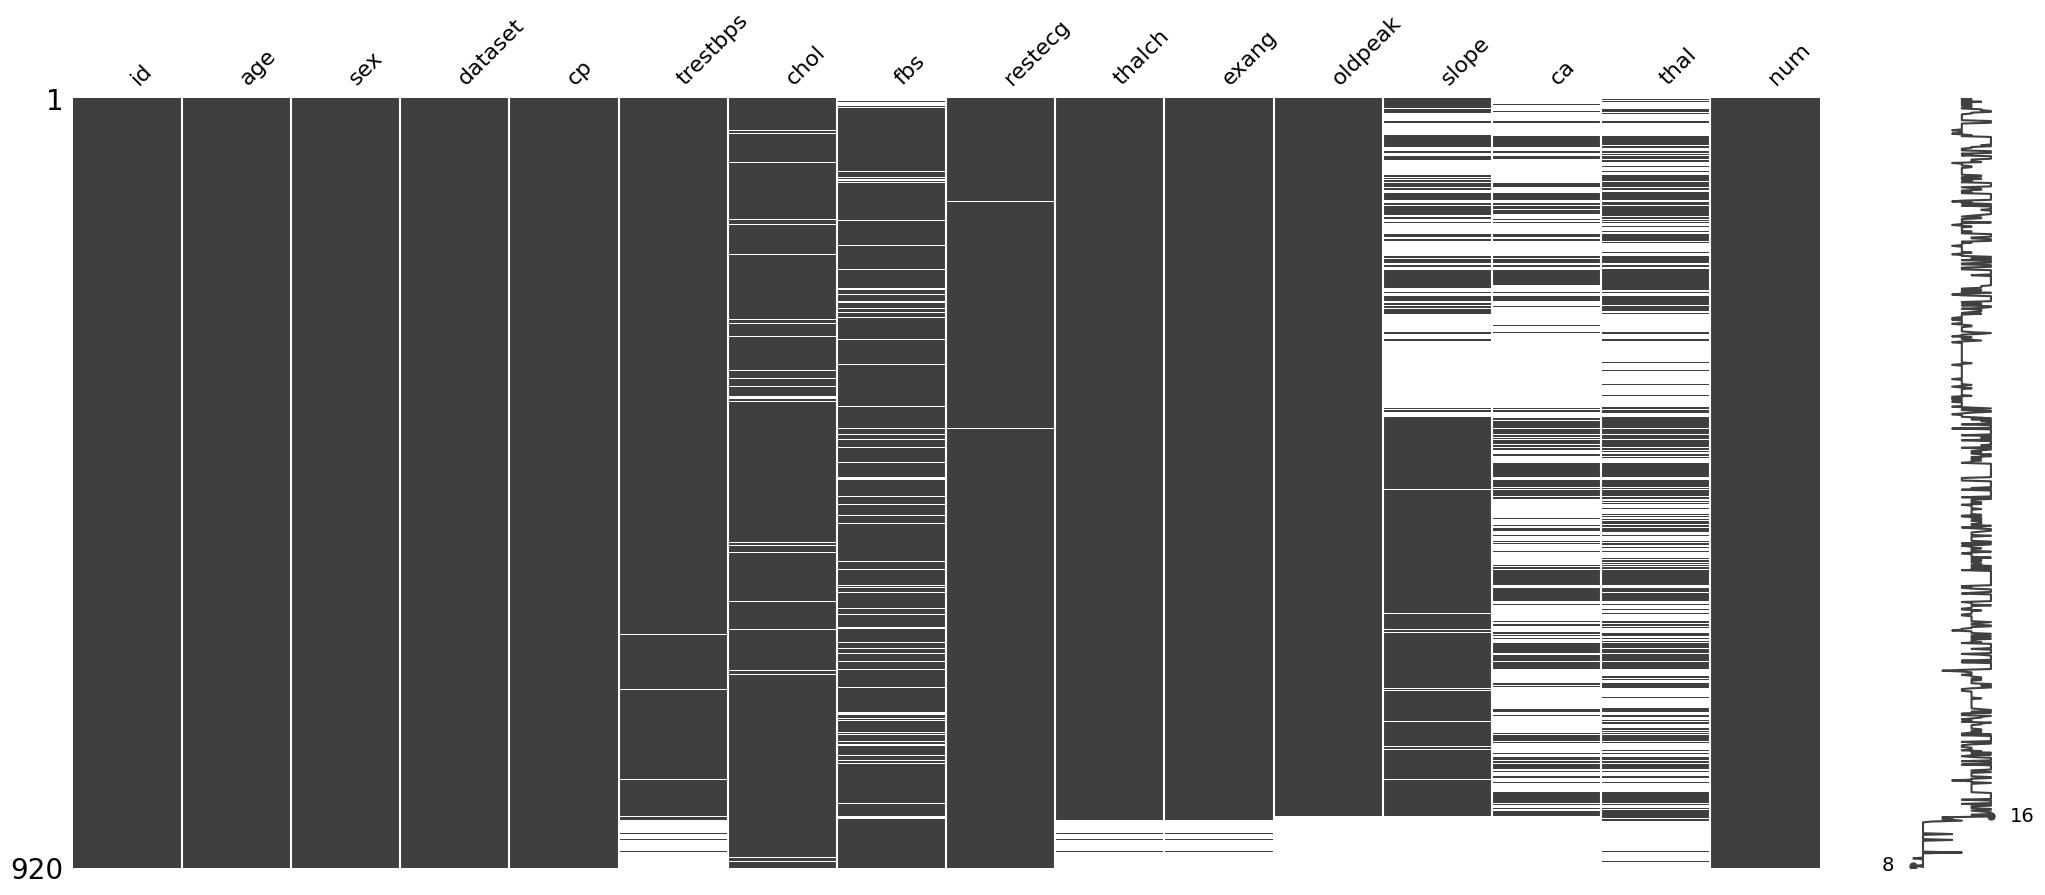

In [11]:
sorted = data.sort_values('oldpeak')
msno.matrix(sorted); plt.show()

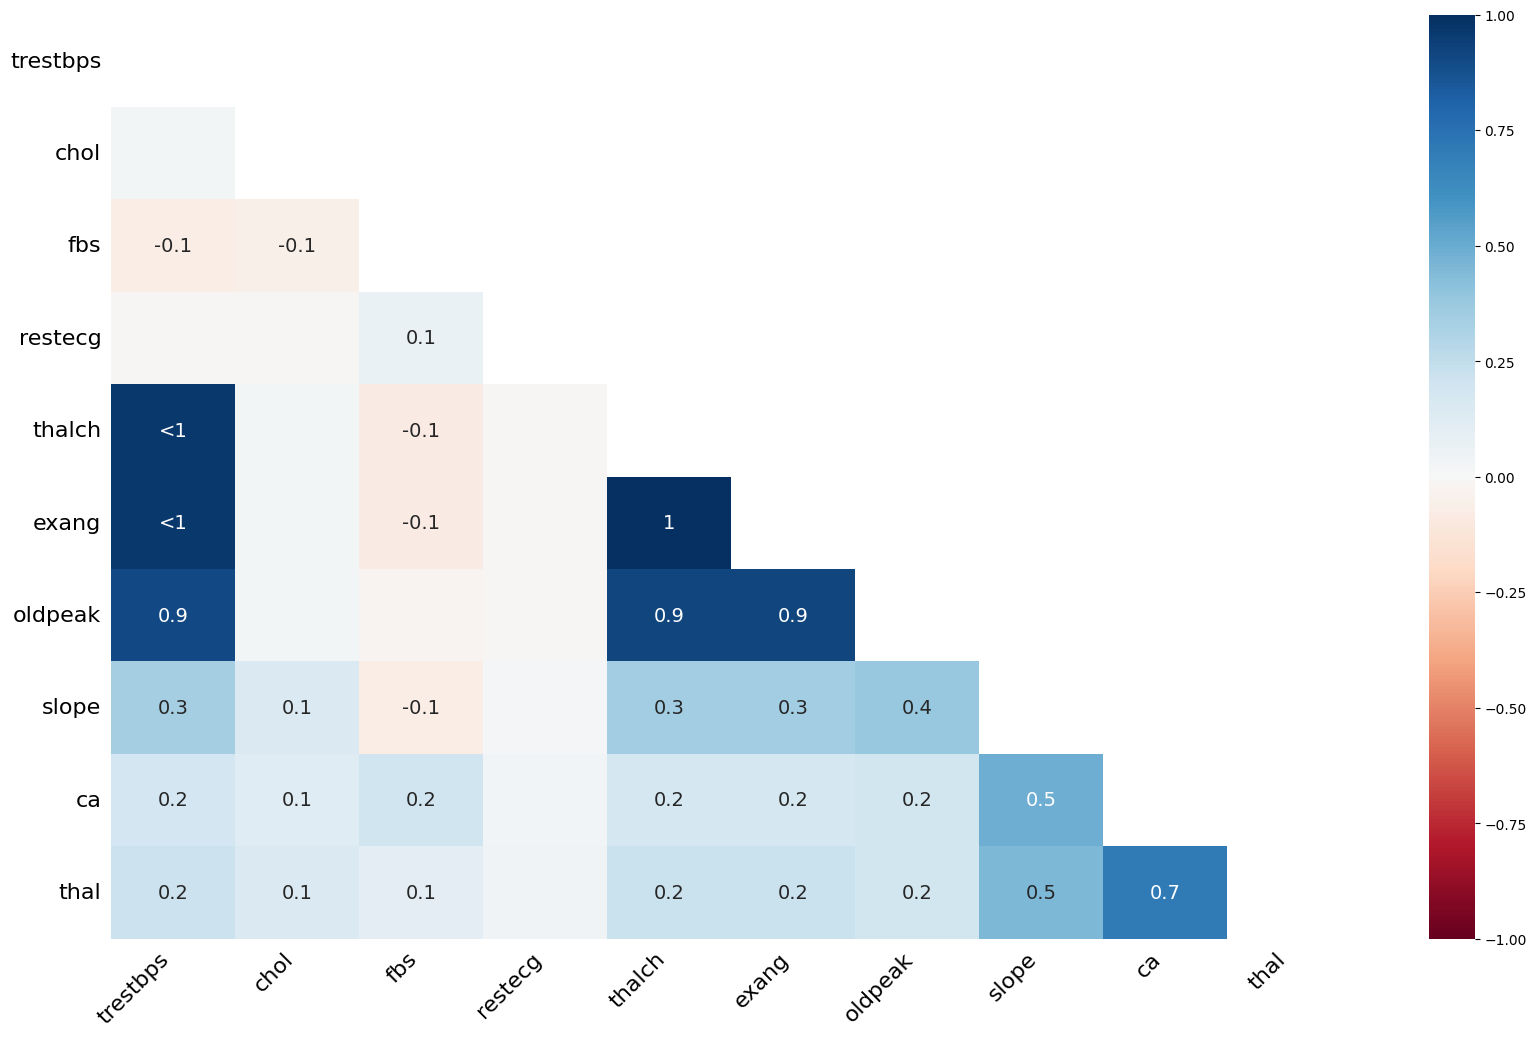

In [12]:
# Carte thérmique heat map de correlation:
msno.heatmap(data); plt.show()

### Que pouvez vous dire des 2 graphiques précédents ? À qoui ils servent ? <br>
- le premier permet de visualiser la répartition des valeurs manquantes pour chacune des variables <br>
- le deuxieme permet de visualiser le coefficient de corrélation des valeurs manquantes <br><br>
on observe forte corrélation entre trestbps et oldpeak,exang,thalch. ca et thal. thalch et exang

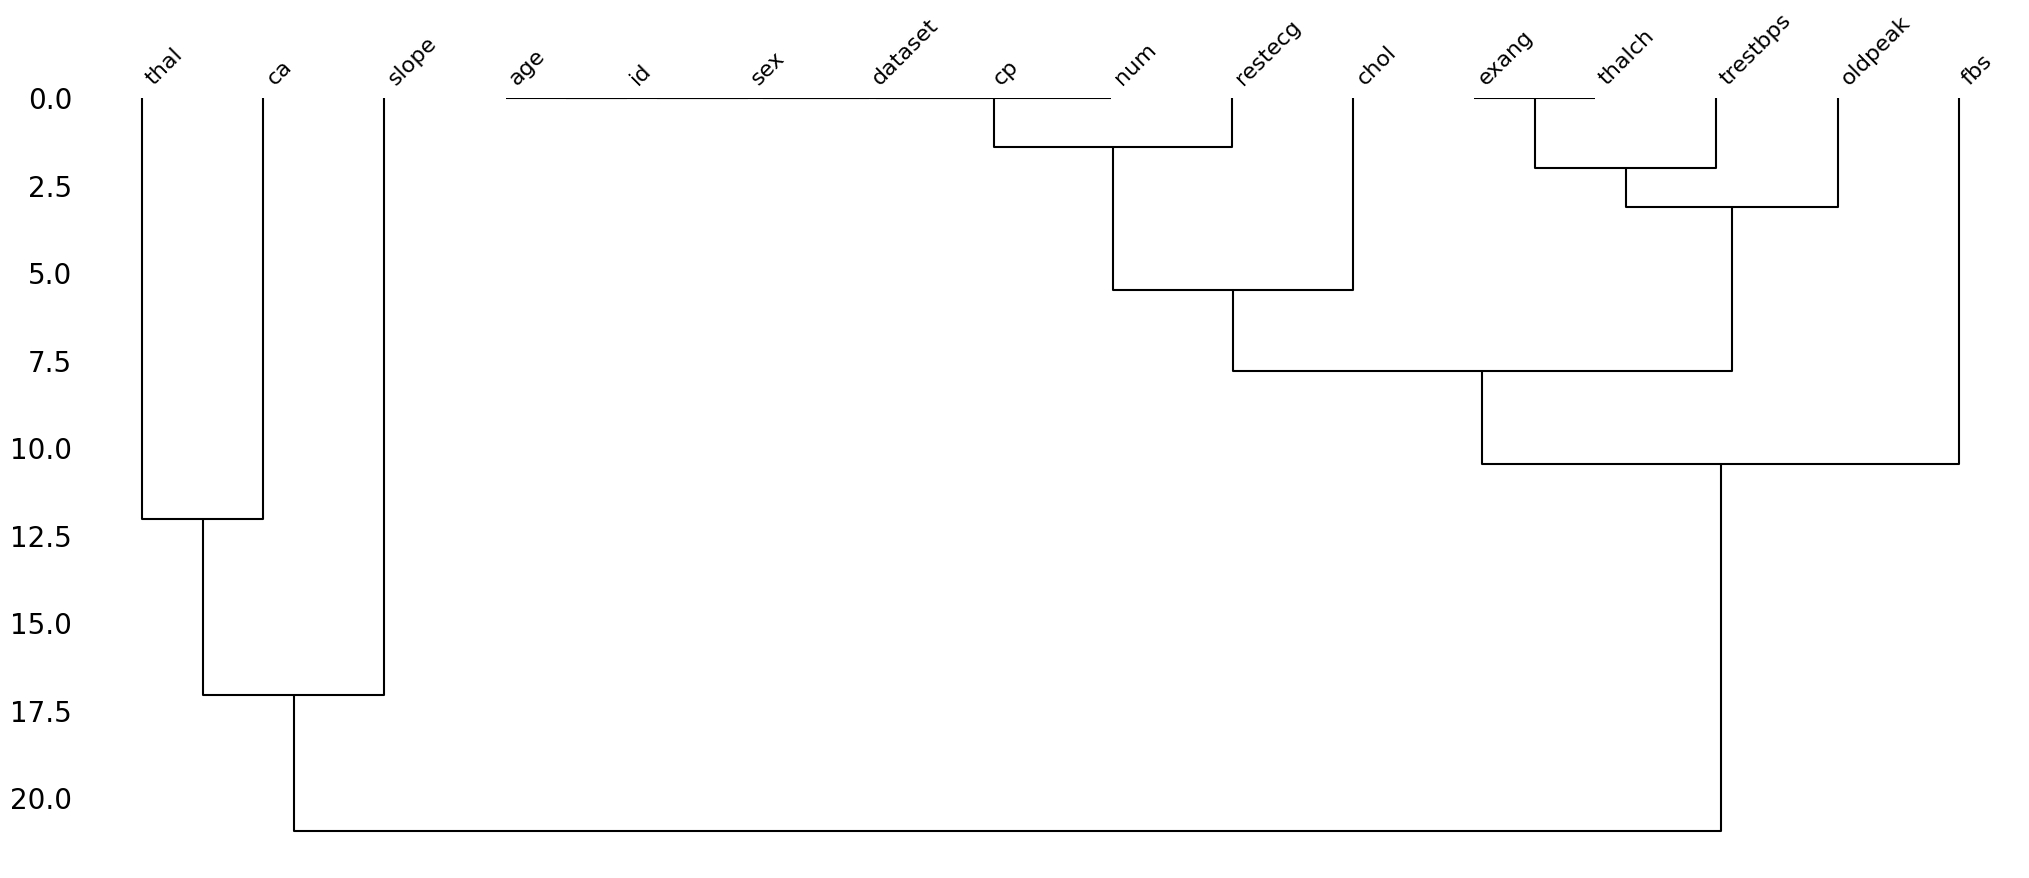

In [13]:
# Autre visualisation : le dendrogramme
msno.dendrogram(data); plt.show()

permet de visualiser comment les valeurs manquantes des différentes colonnes sont liées entre elles

#### Vouyez vous d’autrés corrélations ? Que pouvez vous dire de ces 2 groupes de corrélation ? <br>
- on vois que les variables age, id,sex, dataset,cp et num ont une corrélation null aves les autres variables.  
- on observe deux groupes fortement corrélés entre eux mais les deux groupes doivent etre analysées séparements 

### 5. Méthodes

#### Question : pour quoi XGBoost a été choisi pour cette étude ?<br>

XGBoost est plus précis que les autres models de performance.


In [28]:
def read_data():
    """
    Reads the 'Heart disease' dataset, performs some editing, and returns it.
    """

    df = pd.read_csv("heart_disease_uci.csv")
    # ELLE FAIT QOUI CETTE INSTRUCTION ?
    # créer DataFrame pandas à partir du fichier csv
    
    df['num'] = df['num'].replace({2: 1, 3: 1, 4: 1})
    # ELLE FAIT QUOI CETTE INSTRUCTION ?
    # remplace les 2,3 et 4 par dans 1 dans la colonne 'num'. transforme cette colonne en binaire 
    # ( diagnosis of heart disease (angiographic disease status)
    # -- Value 0: < 50% diameter narrowing
    # -- Value 1: > 50% diameter narrowing)
    
    df = df.drop('id', axis=1)
    # ELLE FAIT QUI CETTE INSTRUCTION ?
    # Cette instruction supprime colonne 'id'
    
    df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
    # ELLE FAIT QUOI CETTE INSTRUCTION ?
    # permet de convertir toutes les colonnes de type object en type category
    
    categorical_columns = df.select_dtypes(include=['category']).columns
    # Convert categorical to numerical
    
    label_encoder = LabelEncoder()
    # ELLE FAIT QUOI CETTE INSTRUCTION ?
    # creer instance de LabelEncoder() pour convertir des valeurs catégorielles en nombres entier
    
    
    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column])
    return df

def split_dataset(df):
    """
    Splits the dataset into training and testing sets.
    Parameters: df (pd.DataFrame): The input dataset.
    Returns: X_train, X_test, y_train, y_test: Training and testing sets for features
    and labels.
    """
    # ELLE FAIT QUOI CETTE INSTRUCTION ?
    # créer dataframe pandas et met tout sauf la colonne "num"
    X = df.drop('num', axis=1)
    
    # ELLE FAIT QUOI CETTE INSTRUCTION ?
    # créer variable y avec la colonne 'num' pour la garder séparément  
    y = df['num']

    # ELLE FAIT QUOI CETTE INSTRUCTION ?
    # prend x et y et les divises en deux parties, une pour l'entrainement et une pour le test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
    random_state=42)
    print(f'Size of the Train: {X_train.shape[0]}')
    print(f'Size of the Test: {X_test.shape[0]}')
    return X_train, X_test, y_train, y_test

def train_model_XGBoost(X_train, X_test, y_train, y_test):
    """
    Trains an XGBoost model on the given training set and evaluates it on the test set.
    Parameters: X_train, X_test, y_train, y_test: Training and testing sets for
    features and labels.
    # ELLE RETOURNE QUOI?
    """
    # On fait qoui ici?
    # créer un modèle XGBoost et on lui donne les données d'entrainement 
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)
    
    # On fait qoui ici?
    # on lui donne les données de test pour qu'il fasse des prédictions et on compare les prédictions avec les vraies réponses 
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy XGBoost: {accuracy}\n")
    return accuracy

def train_model_random_forest(X_train, X_test, y_train, y_test):
    """
    Creates and trains a RandomForest model on the given training set
    and evaluates its performance on the test set.
    Parameters:
    - X_train, X_test, y_train, y_test: Training and testing sets for features and
    labels.
    Returns:
    - accuracy (float): Accuracy score of the trained model on the test set.
    """
    # On fait qoui ici?
    # on créer un model de random forest et on l'entraine avec les données de train
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    
    # On fait qoui ici?
    # on test avec les données test et on vérifie sa précision avec les données vraies données 
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}\n")
    return accuracy

# Pour comparer la précision des méthodes
accuracies = {}

##### Indiquer en quelques lignes comment marche la méthode de forêts aléatoires (random forest) ? A quoi sert-elle ? <br>
C'est un groupe d'arbre qui prennent chacun une prediction et ensuite on prend une moyenne des prédictions. Comme elle utilise plusieurs arbres au lieu d'un seul elle est souvent plus fiable  


#### 5.1. Ignorer les données manquantes

In [29]:
# Read and preprocess the dataset
df = read_data()
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(df)
# Train an XGBoost model on the dataset without handling missing values
accuracy_no_handling = train_model_XGBoost(X_train, X_test, y_train, y_test)
# Store the accuracy of the model without handling missing values in a dictionary
accuracies['No Handling'] = accuracy_no_handling
# A specific data, after the procedure
print("\n------------------\nAfter Imputation: \n")
X_train[(X_train['age']==58.0) & (X_train['sex']==1.0) & (X_train['dataset']==3.0) &
(X_train['chol']==385)]

Size of the Train: 736
Size of the Test: 184
Accuracy XGBoost: 0.8586956521739131


------------------
After Imputation: 



,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
918,58,1,3,0,NaN,385.0,1,0,NaN,2,NaN,3,NaN,3


La précision est d'environ 86%

#### 5.2. Suppression des données manquantes

##### a) Suppression par paire (Pairwise Deletions)

In [30]:
# Read and preprocess the dataset
df = read_data()
# 1. Pairwise Deletions
# Drop rows with any missing values (Pairwise Deletions)
df_pairwise = df.dropna()
# Split the dataset (after Pairwise Deletions) into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(df_pairwise)
# Train a Random Forest model on the dataset after Pairwise Deletions
accuracy_pairwise = train_model_random_forest(X_train, X_test, y_train, y_test)
# Store the accuracy of the model after Pairwise Deletions in a dictionary
accuracies['Pairwise'] = accuracy_pairwise

Size of the Train: 246
Size of the Test: 62
Accuracy: 0.8387096774193549



Avec le random forest et la suppression par paire des données manquantes on a une moins bonne précision (environ 84%), c'est peut être dû à la suppression des données manquantes car la taille de l'ensemble de données d'entrainement est moins importante, 736 pour le train et 184 pour les tests contre 246 et 62 apres suppression par paire. 

##### b) Suppressions par liste (Listwise Deletions)

In [8]:
# Read and preprocess the dataset
df = read_data()
# 2. Listwise Deletions
# Drop rows with missing values in specific columns
df_listwise = df.dropna(subset=['trestbps', 'chol', 'thalch', 'oldpeak', 'ca'])
# Split the dataset (after Listwise Deletions) into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(df_listwise)
# Train a Random Forest model on the dataset after Listwise Deletions
accuracy_listwise = train_model_random_forest(X_train, X_test, y_train, y_test)
# Store the accuracy of the model after Listwise Deletions in a dictionary
accuracies['Listwise'] = accuracy_listwise

Size of the Train: 246
Size of the Test: 62
Accuracy: 0.8548387096774194



on remarque qu'on a autant de données que apres la suppression par paire (246 et 62) mais la precision est tres proche de celle sans suppression des données. cette methode de suppression à l'air plus "intelligente" que la précédente

##### c) Élimination de variables complètes (Dropping Entire Columns)

In [9]:
# Read and preprocess the dataset
df = read_data()
# 3. Dropping Entire Columns
# Drop entire columns with any missing values
df_dropping_entire_columns = df.dropna(axis=1)
# Split the dataset (after Dropping Entire Columns) into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(df_dropping_entire_columns)
# Train a Random Forest model on the dataset after Dropping Entire Columns
accuracy_dropping_entire_columns = train_model_random_forest(X_train, X_test, y_train,
y_test)
# Store the accuracy of the model after Dropping Entire Columns in a dictionary
accuracies['Dropping Entire Columns'] = accuracy_dropping_entire_columns
# A specific data, after the procedure
print("\n------------------\nAfter Imputation: \n")
X_train[(X_train['age']==58.0) & (X_train['sex']==1.0) & (X_train['dataset']==3.0) &
(X_train['restecg']==0) & (X_train['exang']==2)]

Size of the Train: 736
Size of the Test: 184
Accuracy: 0.8206521739130435


------------------
After Imputation: 



,age,sex,dataset,cp,fbs,restecg,exang,slope,thal
918,58,1,3,0,1,0,2,3,3


la precision est moins bonne, le mieux est de conserver les valeurs manquantes. 

#### 5.3. Remplissage statistique de données manquantes

##### a. Moyenne et Médiane

In [31]:
def impute_and_train(X_train, y_train, X_test, y_test, strategy):
    """
    Imputes missing values in the training and testing sets using the specified strategy,
    trains a Random Forest model, and evaluates its performance on the test set.
    Parameters:
    - X_train, y_train: Training features and labels.
    - X_test, y_test: Testing features and labels.
    - strategy (str): Imputation strategy to handle missing values ('mean' or 'median').
    Returns:
    - accuracy (float): Accuracy score of the model on the test set.
    """
    # Impute missing values
    imputer = SimpleImputer(strategy=strategy)
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train),
    columns=X_train.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    # Train a Random Forest model on the imputed training set
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_imputed, y_train)
    # Evaluate the model on the imputed test set
    y_pred = rf_model.predict(X_test_imputed)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n\nImputation strategy: {strategy}")
    print(f"Accuracy: {accuracy}\n")
    return accuracy, X_train_imputed

# Read and preprocess the dataset
df = read_data()
X_train, X_test, y_train, y_test = split_dataset(df)

# Train the model using different imputation strategies
strategies = ['mean', 'median']

for strategy in strategies:
    accuracy, X_train_imputed = impute_and_train(X_train, y_train, X_test, y_test,strategy)
    accuracies[strategy] = accuracy
    # A specific data, after the procedure
    print("\n------------------After Imputation: \n")
    print(X_train_imputed[(X_train_imputed['age']==58.0) & (X_train_imputed['sex']==1.0)
    & (X_train_imputed['dataset']==3.0) & (X_train_imputed['chol']==385)])
    print("\n------------------------------------------------")

Size of the Train: 736
Size of the Test: 184


Imputation strategy: mean
Accuracy: 0.8478260869565217


------------------After Imputation: 

     age  sex  dataset   cp    trestbps   chol  fbs  restecg      thalch  \
16  58.0  1.0      3.0  0.0  131.668596  385.0  1.0      0.0  137.383285   

    exang   oldpeak  slope     ca  thal  
16    2.0  0.881187    3.0  0.688   3.0  

------------------------------------------------


Imputation strategy: median
Accuracy: 0.8532608695652174


------------------After Imputation: 

     age  sex  dataset   cp  trestbps   chol  fbs  restecg  thalch  exang  \
16  58.0  1.0      3.0  0.0     130.0  385.0  1.0      0.0   140.0    2.0   

    oldpeak  slope   ca  thal  
16      0.5    3.0  0.0   3.0  

------------------------------------------------


Les deux méthodes donnent des résultats très similaires, mais la méthode de la moyenne est légèrement plus précise

#### 5.4. Autres méthodes (Remplissage avant - arrière - Interpolation linéaire) / (Forward Fill - Backward Fill - Linear Interpolation)

In [32]:
def fill_missing_values(data, method='ffill'):
    """
    Fills missing values in the dataset using specified methods: 'ffill', 'bfill', or
    'linear'.
    Parameters:
    - data (pd.DataFrame): Input dataset.
    - method (str): Method for filling missing values ('ffill', 'bfill', or 'linear').
    Returns:
    - filled_data (pd.DataFrame): Dataset with filled missing values.
    """
    if method == 'ffill':
        filled_data = data.fillna(method='ffill')
    elif method == 'bfill':
        data['ca'] = data['ca'].fillna(data['ca'].mean())
        filled_data = data.fillna(method='bfill')
    else:
        filled_data = data.interpolate(method='linear', limit_direction='forward')
    return filled_data

# Lit et pretraite les donnees
data = read_data()

# On fait qoui ici?
# on remplit les valeurs manquantes dans les données avec la méthode Forward Fill et on divise les données en ensembles d'entraînement et de test
filled_data_ffill = fill_missing_values(data, method='ffill')
X_train_ffill, X_test_ffill, y_train_ffill, y_test_ffill = split_dataset(filled_data_ffill)

# On fait qoui ici?
# on remplit les valeurs manquantes dans les données avec la méthode Backward Fill et on divise ces données en ensembles d'entraînement et de test 
filled_data_bfill = fill_missing_values(data, method='bfill')
X_train_bfill, X_test_bfill, y_train_bfill, y_test_bfill = split_dataset(filled_data_bfill)

# On fait qoui ici?
# on remplit les valeurs manquantes dans les données avec la méthode d'Interpolation linéaire et on divise ces données en ensembles d'entraînement et de test 
filled_data_linear = fill_missing_values(data, method='linear')
X_train_linear, X_test_linear, y_train_linear, y_test_linear = split_dataset(filled_data_linear)

# A specific data, after the procedure
# Train Random Forest models on datasets with different filling methods
print("\n\n\nFfill method:")
accuracy_ffill = train_model_random_forest(X_train_ffill, X_test_ffill, y_train_ffill,
y_test_ffill)
print("\n------------------After Imputation: \n")
print(X_train_ffill[(X_train_ffill['age']==58.0) & (X_train_ffill['sex']==1.0) &
(X_train_ffill['dataset']==3.0) & (X_train_ffill['chol']==385)]
)
print("\n----------------------------")
print("\n\n\nBfill method:")
accuracy_bfill = train_model_random_forest(X_train_bfill, X_test_bfill, y_train_bfill,
y_test_bfill)
print("\n------------------\nAfter Imputation: \n")
print(X_train_bfill[(X_train_bfill['age']==58.0) & (X_train_bfill['sex']==1.0) &
(X_train_bfill['dataset']==3.0) & (X_train_bfill['chol']==385)]
)
print("\n----------------------------")
print("\n\n\nLinear method:")
accuracy_linear = train_model_random_forest(X_train_linear, X_test_linear,
y_train_linear, y_test_linear)

print("\n------------------\nAfter Imputation: \n")
print(X_train_linear[(X_train_linear['age']==58.0) & (X_train_linear['sex']==1.0) &
(X_train_linear['dataset']==3.0) & (X_train_linear['chol']==385)]
)
print("\n----------------------------")
# Store accuracies in a dictionary for comparison
accuracies['Ffill'] = accuracy_ffill
accuracies['Bfill'] = accuracy_bfill
accuracies['Linear'] = accuracy_linear

C:\Users\sunny\AppData\Local\Temp\ipykernel_22816\2726212920.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = data.fillna(method='ffill')
C:\Users\sunny\AppData\Local\Temp\ipykernel_22816\2726212920.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = data.fillna(method='bfill')


Size of the Train: 736
Size of the Test: 184
Size of the Train: 736
Size of the Test: 184
Size of the Train: 736
Size of the Test: 184



Ffill method:
Accuracy: 0.8369565217391305


------------------After Imputation: 

     age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
918   58    1        3   0     122.0  385.0    1        0   100.0      2   

     oldpeak  slope   ca  thal  
918      0.0      3  0.0     3  

----------------------------



Bfill method:
Accuracy: 0.8315217391304348


------------------
After Imputation: 

     age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
918   58    1        3   0     120.0  385.0    1        0    93.0      2   

     oldpeak  slope        ca  thal  
918      0.0      3  0.676375     3  

----------------------------



Linear method:
Accuracy: 0.842391304347826


------------------
After Imputation: 

     age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
918   58    1        

Les trois méthodes donnent des résultats similaires en termes de précision (environ 84%). Après avoir rempli les données, les valeurs de certaines colonnes changent légèrement, mais l'impact sur la précision reste faible. Par exemple, avec la méthode forward la valeur de la colonne 'ca' est 0, alors qu'avec backward et linear elle a été légèrement ajustée (environ 0.68). Cela montre que toutes les méthodes sont assez bonnes pour cette tâche.

#### 5.5. Techniques avancées d’imputation (Prédiction de valeurs manquantes) (KNN – Régression linéaire - Random Forest) 

#####  a. K-Nearest Neighbors (KNN) 


In [ ]:
def knn_impute(X_train, X_test, y_train, y_test, k=5):
    """
    Imputes missing values using the K-Nearest Neighbors (KNN) algorithm.
    Parameters:
    - X_train: pandas DataFrame, training dataset
    - X_test: pandas DataFrame, testing dataset
    - y_train: pandas Series, training labels
    - y_test: pandas Series, testing labels
    - k: int, number of neighbors for KNN imputation
    Returns:
    - X_train_imputed, X_test_imputed, y_train, y_test: pandas DataFrames and Series,
      imputed training and testing datasets along with labels
    """
    knn_imputer = KNNImputer(n_neighbors=k)
    X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), 
columns=X_train.columns)
    X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)
    return X_train_imputed, X_test_imputed, y_train, y_test
 # Read and preprocess the dataset
df = read_data()
X_train, X_test, y_train, y_test = split_dataset(df)
 # On fait qoui ici?
 # On rempli les valeur manquantes dans X_train et Y_train avec la méthode des KNN dans laquelle on utilise la moyenne des K-plus-proches voisins, ici k=10
X_train_imputed, X_test_imputed, y_train, y_test = knn_impute(X_train, X_test, y_train, 
y_test, k=10)
# On fait qoui ici?
# On entraine le modèle de Random Forest avec les données corrigées du grâce au KNN
accuracy_knn = train_model_random_forest(X_train_imputed, X_test_imputed, y_train, 
y_test)
 # Store the accuracy of the model with KNN imputation in a dictionary
accuracies['KNN'] = accuracy_knn
 # A specific data, after the procedure
print("\n------------------\nAfter Imputation KNN: \n")
print(
X_train_imputed[(X_train_imputed['age']==58.0) & (X_train_imputed['sex']==1.0) & 
(X_train_imputed['dataset']==3.0) & (X_train_imputed['chol']==385)])

Size of the Train: 736
Size of the Test: 184
Accuracy: 0.8641304347826086


------------------
After Imputation KNN: 

     age  sex  dataset   cp  trestbps   chol  fbs  restecg  thalch  exang  \
16  58.0  1.0      3.0  0.0     141.4  385.0  1.0      0.0   125.6    2.0   

    oldpeak  slope   ca  thal  
16     0.45    3.0  0.7   3.0  


##### b. Régression linéaire

In [ ]:
def linear_regression_impute(df, target_column, feature_columns):
    """
    Imputes missing values using linear regression.
    Parameters:
    - df: pandas DataFrame, input dataset
    - target_column: str, target column with missing values to be imputed
    - feature_columns: list, feature columns used to predict missing values
    Returns:
    - pd.DataFrame, dataset with imputed missing values
    """
    # Separate missing and non-missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df.dropna(subset=[target_column])
 # On fait qoui ici?
 # on sépare clairement les variable dépendantes (target) des variables indépendantes (features) 
    X_train = df_not_missing[feature_columns]
    y_train = df_not_missing[target_column]
# On fait qoui ici?
# on crée un modèle de régression linéaire qu'on entrainera avec les variables dépendantes et indépendantes (X et Y)
    model = LinearRegression()
    model.fit(X_train, y_train)
 # On fait qoui ici?
 # ici, au lieu d'utiliser la moyenne ou les médianes comme dans d'autres méthodes, on va prédire les valeurs manquantes selon les variables présentes
    X_missing = df_missing[feature_columns]
    predicted_values = model.predict(X_missing)
 # On fait qoui ici?
 # On fait un dataset dans lequel les X manquants ont été remplacés 
    df_filled = df.copy()
    df_filled.loc[df[target_column].isnull(), target_column] = predicted_values
    return df_filled
 # Impute missing values using linear regression
target_columns_to_impute = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
feature_columns_for_imputation = ['age', 'sex', 'dataset', 'cp', 'fbs', 'restecg', 
'exang', 'slope', 'thal']
linear_data = read_data()
for target_column in target_columns_to_impute:
   linear_data = linear_regression_impute(linear_data, target_column, 
feature_columns_for_imputation)
 # Split the dataset after linear regression imputation
X_train, X_test, y_train, y_test = split_dataset(linear_data)
 # On fait qoui ici?
 # On vérifie si l'implémentation du modèle de régression linéaires améliore la précision du random forest
accuracy_linear_reg = train_model_random_forest(X_train, X_test, y_train, y_test)
 # Store the accuracy of the model with linear regression imputation in a dictionary
accuracies['Linear Regression'] = accuracy_linear_reg
 # A specific data, after the procedure
print("\n------------------\nAfter Imputation: \n")
X_train[(X_train['age']==58.0) & (X_train['sex']==1.0) & (X_train['dataset']==3.0) & (X_train['chol']==385)]

Size of the Train: 736
Size of the Test: 184
Accuracy: 0.8478260869565217


------------------
After Imputation: 



,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
918,58,1,3,0,143.469093,385.0,1,0,104.142288,2,0.712014,3,0.757839,3


##### c. Random Forest 

In [ ]:
def random_forest_impute(df, target_column, feature_columns):
    """
    Imputes missing values using Random Forest.
    Parameters:
    - df: pandas DataFrame, input dataset
    - target_column: str, target column with missing values to be imputed
    - feature_columns: list, feature columns used to predict missing values
    Returns:
    - pd.DataFrame, dataset with imputed missing values
    """
    # Separate missing and non-missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df.dropna(subset=[target_column])
    # Create training and test sets for the model
    X_train = df_not_missing[feature_columns]
    y_train = df_not_missing[target_column]
    # Create a Random Forest regression model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
 # On fait qoui ici?
 # On utilise les autres variables de random forest et leur relation afin de predire les valeurs manquantes
    X_missing = df_missing[feature_columns]
    predicted_values = model.predict(X_missing)
 # On fait qoui ici?
 # On fait un dataset dans lequel les données manquantes sont remplacées par les prédictions antérieures
    df_filled = df.copy()
    df_filled.loc[df[target_column].isnull(), target_column] = predicted_values
    return df_filled
 # Impute missing values using Random Forest
target_columns_to_impute = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
feature_columns_for_imputation = ['age', 'sex', 'dataset', 'cp', 'fbs', 'restecg', 
'exang', 'slope', 'thal']
random_data = read_data()
for target_column in target_columns_to_impute:
    random_data = random_forest_impute(random_data, target_column, 
feature_columns_for_imputation)
 # Split the dataset after Random Forest imputation
X_train, X_test, y_train, y_test = split_dataset(random_data)
 # Train a Random Forest model on the imputed dataset
accuracy_random_forest = train_model_random_forest(X_train, X_test, y_train, y_test)
 # Store the accuracy of the model with Random Forest imputation in a dictionary
accuracies['Random Forest'] = accuracy_random_forest
 # A specific data, after the procedure
print("\n------------------\nAfter Imputation: \n")
X_train[(X_train['age']==58.0) & (X_train['sex']==1.0) & (X_train['dataset']==3.0) & 
(X_train['chol']==385)]

Size of the Train: 736
Size of the Test: 184
Accuracy: 0.8478260869565217


------------------
After Imputation: 



,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
918,58,1,3,0,158.763333,385.0,1,0,114.42,2,0.892,3,1.285667,3


###  6. Résultats et codes

Conlusion : supprimer trop d’informations nuit à la qualité du modèle. 

Critiques des méthodes utilisées :

#### Tables de performances : 

En regardant les résultats, il devient évident que supprimer trop d’informations nuit à la précision du modèle. Donc, toutes les méthodes qui ne font qu'écarter les variables sont à écarter.

TODO


| Technique d'imputation                          | Précision (Accuracy) |
|------------------------------------------------|----------------------|
| **Random Forest**                              | 0.8478               |
| **Régression linéaire**                        | 0.8478               |
| **KNN (K-Nearest Neighbors)**                  | 0.8641               |
| **Remplissage avant (Forward Fill)**          | 0.8370               |
| **Remplissage arrière (Backward Fill)**       | 0.8315               |
| **Méthode linéaire (Interpolation)**          | 0.8424               |
| **Imputation par la moyenne**                 | 0.8478               |
| **Imputation par la médiane**                 | 0.8533               |
| **Élimination de variables complètes**        | 0.8207               |
| **Suppressions par liste (Listwise Deletion)** | 0.8548               |
| **Suppression par paire (Pairwise Deletion)**  | 0.8387               |
| **Ignorer les données manquantes (XGBoost)**  | 0.8587               |

En effet, certaines méthode ont des résultats qui sont très similaire, voire égaux. Ceci est tout à fait plausible et signifie qu'ils utilisent des relations et des procédés qui sont similaires. Ici, il semble que les techniques avancées d’imputation de random forest n'améliore pas la précision par rapport à la régression linéaire, ce qui en soit n'est pas une mauvaise chose et signifie simplement que les relations ne sont pas très complexe et sont presque linéaire. Outres ces résultats, il est normal que les résultats soient tous similaire puisque les valeurs manquantes ne perturbent pas les résultats puisque le modèle est fortement corrélé.

Meilleur méthode : XGboost, cependant, il n'est pas idéale d'ignorer les données manquantes. Donc, dans les méthodes qui substituent les données manquantes, KNN est la meilleur technique. Non seulement elle est la plus précise et en plus, elle remplace les valeurs manquantes d'une manière tout à fait logique soit, ici, en prenant les 10 voisins les plus proches. Il pourrait etre interessant d'itérer sur K afin de trouver lequel serait le plus optimal.
